In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

# Funs

In [348]:
def prep_data(sim):
    X = np.stack([eeg.average().data for eeg in sim.eeg_data])
    y = np.stack([src.data for src in sim.source_data])
    for i, (x_sample, y_sample) in enumerate(zip(X, y)):
        # X[i] = np.stack([(x - np.mean(x)) / np.std(x) for x in x_sample.T], axis=0).T
        # y[i] = np.stack([ y / np.max(abs(y)) for y in y_sample.T], axis=0).T

        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] /= np.linalg.norm(X[i])
        y[i] /= np.max(abs(y[i]))

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    
    return X, y
    
def make_mask(y, thresh=0.001):
    y_mask = np.zeros((y.shape[0], y.shape[-1]))
    for i, y_samp in enumerate(y):
        yy = abs(y_samp).mean(axis=0)
        

        y_mask[i] = (yy > yy.max()*thresh).astype(int)
    return y_mask

def get_components(X, leadfield_norm):
    for i, x_sample in enumerate(X):
        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] /= np.linalg.norm(X[i])

    X_components = np.stack([leadfield_norm.T @ X_sample.T for X_sample in X], axis=0)
    X_components = np.swapaxes(X_components, 1, 2)
    X_components = np.stack([XX / np.linalg.norm(XX) for XX in X_components], axis=0)
    return np.abs(X_components)


# Forward

In [ ]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)

n_chans, n_dipoles = leadfield.shape

# Simulation

In [386]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.01, target_snr=1e99, source_number_weighting=False)


sim = Simulation(fwd, info, settings).simulate(2000)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

# stc.data /= abs(stc.data).max()
# brain = stc.plot(**pp)
# brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
#                font_size=14)
# evoked.plot_joint()

X, y = prep_data(sim)
y_mask = make_mask(y, thresh=0.001)
X_components = get_components(X, leadfield_norm)


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2000/2000 [00:00<00:00, 14854.48it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2000/2000 [00:07<00:00, 278.40it/s]


# Train

## FC Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Dropout
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels, n_dipoles = leadfield.shape
n_time = X_components.shape[1]

y_mask_new = deepcopy(y_mask)
y_mask_new = y_mask_new[:, np.newaxis]
y_mask_new = np.repeat(y_mask_new, n_time, axis=1)

n_dense_units = 300
n_lstm_units = 64
activation_function = "elu"
batch_size = 32
epochs = 50
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_dipoles), name='Input')

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC1'))(inputs)

fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC2'))(fc1)

fc3 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC3'))(fc2)


# Masking
# lstm1 = Bidirectional(LSTM(n_lstm_units, return_sequences=False, 
#             input_shape=(None, n_dense_units)), 
#             name='LSTM1')(fc3)
# lstm1 = Dense(n_dipoles, 
#             activation="sigmoid", 
#             name='Mask')(lstm1)

out = TimeDistributed(Dense(n_dipoles, 
            activation="softmax", 
            # activity_regularizer=tf.keras.regularizers.L1(l1=0.001),
            name='Output'))(fc3)

# out = multiply([lstm1, out])

model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')
model.compile(loss="binary_crossentropy", optimizer="adam")
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, min_delta=0.00, monitor="val_loss", restore_best_weights=True)]
model.fit(X_components, y_mask_new, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)
# model.fit(X[:, 0], y_mask, epochs=epochs, batch_size=batch_size, validation_split=0.15)

## LSTM

In [387]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, multiply, Dropout, Activation
from tensorflow.keras import backend as K

n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 150
activation_function = "elu"
batch_size = 32
epochs = 40
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_dipoles), name='Input')


fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC1'))(inputs)

fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC2'))(fc1)

lstm1 = LSTM(n_lstm_units, return_sequences=True, return_state=True,
            name='LSTM1')(fc2)[2]

out = Dense(n_dipoles, 
            activation="relu", 
            # activity_regularizer=tf.keras.regularizers.L1(l1=0.0001),
            name='Mask')(lstm1)

model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')
model.compile(loss="mse", optimizer="adam")
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.00, monitor="val_loss", restore_best_weights=True)]

model.fit(X_components[:], y_mask[:], epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)
# model.fit(X[:, 0], y_mask, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "Prelocalizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 1284)]      0         
                                                                 
 time_distributed_24 (TimeDi  (None, None, 300)        385500    
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, None, 300)        90300     
 stributed)                                                      
                                                                 
 LSTM1 (LSTM)                [(None, None, 150),       270600    
                              (None, 150),                       
                              (None, 150)]                       
                                                                 
 Mask (Dense)                (None, 1284)             

# Eval raw

In [389]:
# settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.001, target_snr=1e99)
settings = dict(number_of_sources=2, extents=25, duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
X_test, y_test = prep_data(sim_test)
y_test_mask = make_mask(y_test, thresh=0.001)
X_test_components = get_components(X_test, leadfield_norm)
y_hat = model.predict(X_test_components)
if len(y_hat.shape) == 3:
    y_hat = y_hat[:, 0]

# y_hat = model.predict(X_test[:, 0])

plt.figure()
plt.plot(y_hat[0] / np.linalg.norm(y_hat[0]))

# plt.figure()
plt.plot(y_test_mask[0] / np.linalg.norm(y_test_mask[0]))
print(pearsonr(y_test_mask[0], y_hat[0]))

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1947.22it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 267.11it/s]

1/1 [==============================] - 0s 18ms/step
(0.1116144003749671, 6.120740532781974e-05)


# Eval Source

In [370]:
settings = dict(number_of_sources=5, extents=1, duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
stc = sim_test.source_data[0]
evoked = sim_test.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X_test, y_test = prep_data(sim_test)
y_mask_test = make_mask(y_test, thresh=0.001)
X_test_components = get_components(X_test, leadfield_norm)

gammas = model.predict(X_test_components)[0]

# gammas[gammas<gammas.max()*0.1] = 0
# gammas[gammas<np.percentile(gammas, 90)] = 0

from invert.util import find_corner


if len(gammas.shape) == 2:
    for i in range(len(gammas)):
        gammas[i][gammas[i]<gammas[i].max()*0.01] = 0

    y_hat = np.stack([ 
        np.linalg.pinv(np.diag(gamma!=0) @ leadfield.T).T @ X_test[0,0] 
        for gamma in gammas], axis=1)
    
    # y_hat = np.stack([ np.diag(gamma) @ leadfield.T @ X_test[0,0] for gamma in gammas], axis=1)
    x_hat = leadfield @ y_hat
else:
    # Thresholding Gammas:
    idc = np.argsort(gammas)[::-1]
    iters = np.arange(len(gammas))
    idx = find_corner(iters, gammas[idc])
    thresh = gammas[idc[idx]]
    gammas[gammas<thresh] = 0
    gidx = gammas!=0
    y_hat = np.linalg.pinv(np.diag(gammas!=0).astype(int) @ leadfield.T).T @ X_test[0].T
    
    x_hat = leadfield @ y_hat

stc_ = stc.copy()
stc_.data = y_hat / abs(y_hat).max()

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted Mask', 'title',
               font_size=14)
evoked_ = mne.EvokedArray(x_hat, info)
evoked_.plot_joint()

plt.figure()
plt.plot(y_hat[:, 0] / np.linalg.norm(y_hat[:, 0]))

# plt.figure()
plt.plot(y_mask_test[0] / np.linalg.norm(y_mask_test[0]))


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 286.50it/s]

Using control points [0.        0.        0.4338281]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1/1 [==============================] - 0s 19ms/step
Using control points [5.10809942e-15 2.41159405e-03 3.07638134e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


Using control points [0.         0.         0.23532177]
Using control points [2.24971268e-15 1.12842289e-03 1.25727031e-01]
Using control points [2.24971268e-15 1.12842289e-03 1.25727031e-01]


# LSTM Matching Pursuit

In [417]:
settings = dict(number_of_sources=2, extents=(1, 26), duration_of_trial=0.01, target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
stc = sim_test.source_data[0]
evoked = sim_test.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X_test, y_test = prep_data(sim_test)
# y_mask_test = make_mask(y_test, thresh=0.001)
X_test_components = get_components(X_test, leadfield_norm)


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 250.67it/s]

Using control points [0.         0.         0.41031125]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


(10, 1284)
8.212392692945848e-05
6.265314939851885e-05
5.735653516105055e-05
4.422336835064474e-05
3.7251335314880496e-05
3.2539878880020466e-05
1.9535859373155735e-05
1.5383256109174478e-05
1.3633800134510385e-05
1.166564860888322e-05
No projector specified for this dataset. Please consider the method self.add_proj.


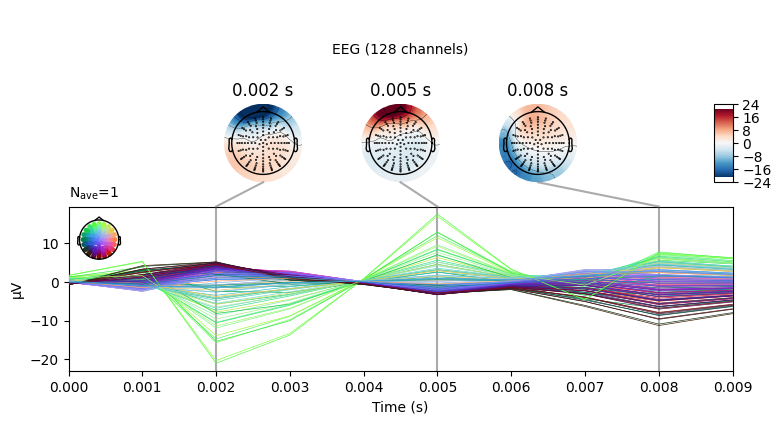

In [418]:
from scipy.stats import pearsonr
max_iter = 10
K = 1
X_test = evoked.data
X_test -= X_test.mean(axis=0)

# dimensions
n_chans, n_dipoles = leadfield.shape
n_time = X_test.shape[-1]

# Predict Gammas
if len(X_test.shape) == 3:
    X_test = X_test[0]

# get initial orthogonal leadfield components
R = deepcopy(X_test)
R_components = get_components(R.T[np.newaxis], leadfield_norm)[0]
residual_norms = [1e99,]
print(R_components.shape)
idc = np.array([])
for i in range(max_iter):

    gammas = abs(model.predict(R_components[np.newaxis], verbose=0)[0])
    # gammas = (gammas/gammas.max()) * np.linalg.norm(R_components, axis=0)
    # gammas = (gammas/gammas.max()) * np.linalg.norm(leadfield_norm.T @ R.T, axis=1)
    # gammas = (gammas/gammas.max()) * np.linalg.norm(leadfield_norm.T @ R.T, axis=1)
    gammas_mp = np.linalg.norm(leadfield_norm.T @ R, axis=1)

    idc_gamma = np.argsort(gammas)[::-1]
    iters = np.arange(len(gammas))
    idx = find_corner(iters, gammas[idc_gamma])
    thresh = gammas[idc_gamma[idx]]
    gammas[gammas<thresh] = 0
    gidx = gammas!=0
    y_hat = np.linalg.pinv(np.diag(gammas!=0).astype(int) @ leadfield.T).T @ X_test
    gammas = np.linalg.norm(y_hat, axis=1)
    gammas /= gammas.max()
    gammas = gammas * gammas_mp

    # gammas = gammas_mp

    # plt.figure()
    # plt.plot(gammas)


    # plt.figure()
    # plt.subplot(211)
    # plt.plot(gammas)
    # plt.title("Gamma")

    
    # plt.subplot(212)
    # plt.plot(gammas)
    # plt.title("Gamma*comp")

    idx = np.argsort(gammas)[-K:]
    idc = np.unique(np.concatenate([idc, idx])).astype(int)
    

    leadfield_pinv = np.linalg.pinv(leadfield[:, idc])
    y_hat = np.zeros((n_dipoles, n_time))
    y_hat[idc] = leadfield_pinv @ X_test

    X_hat = leadfield @ y_hat
    # Rereference and scale predicted EEG
    X_hat -= X_hat.mean(axis=0)
    # X_hat /= np.linalg.norm(X_hat)
    
    # Calculate Residual
    R = X_test - X_hat
    # Rereference and scale predicted Residual
    R -= R.mean(axis=0)

    R_norm = deepcopy(R) /  np.linalg.norm(deepcopy(R))

    R_components = get_components(deepcopy(R).T[np.newaxis], leadfield_norm)[0]
    
    residual_norm = np.linalg.norm(R)
    residual_norms.append( residual_norm )
    # print(idc)
    print(residual_norm)

    # plt.figure()
    # plt.subplot(311)
    # im, _ = mne.viz.plot_topomap(X_test[:,0], info)
    # plt.colorbar(im)
    # plt.title("True")
    # plt.subplot(312)
    # im, _ = mne.viz.plot_topomap(X_hat[:,0], info)
    # plt.colorbar(im)
    # plt.title("Current X_hat")
    # plt.subplot(313)
    # im, _ = mne.viz.plot_topomap(R[:, 0], info)
    # plt.colorbar(im)
    # plt.title("Residual")

    # if residual_norms[-1] >= residual_norms[-2]:
    #     break
    
X_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(X_hat, info)
evoked_.plot_joint()


Using control points [0.         0.         0.49671733]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


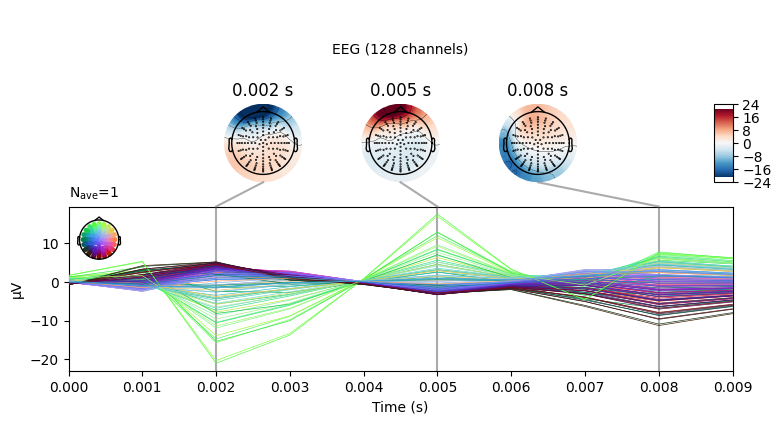

In [419]:
stc_ = stc.copy()
stc_.data = y_hat / abs(y_hat).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Pred', 'title',
               font_size=14)

x_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(x_hat, info)
evoked_.plot_joint()